In [1]:
import pandas as pd
import jieba
import numpy as np
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora, models, similarities
from gensim.corpora import Dictionary

In [2]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [3]:
import re
import math
from gensim.models import TfidfModel

In [4]:
def remove_punc(word_list):
    
    punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."
    word_list = [word for word in word_list if word not in punc]
    
    return word_list

def remove_num(word_list):
    
    word_list = [re.sub(r'[0-9]+', '', word) for word in word_list]
    
    return word_list

def remove_single_character(word_list):
    
    word_list = [word for word in word_list if len(word)>1]
    
    return word_list

def remove_stopwords(word_list,stopwords_list):
    
    word_list = [word for word in word_list if word not in stopwords_list]
    
    return word_list

In [5]:
def aggregate_preprocess(text):
    
    word_cut = jieba.cut(text,HMM=True,use_paddle=True,cut_all=False)
    
    word_cut_list = list(word_cut)
    
    word_cut_list = remove_punc(word_cut_list)
    
    word_cut_list = remove_num(word_cut_list)
    
    word_cut_list = remove_single_character(word_cut_list)
    
    word_cut_list = remove_stopwords(word_cut_list,stopwords_list)
    
    return word_cut_list

### Import Text

In [6]:
data_directory = "data/"
file = "content.csv"

df = pd.read_csv(data_directory+file)
df["date"] = pd.to_datetime(df["date"])

text = list(df["content"])


In [7]:
stopwords_directory = "data/stopwords/"
file_1 = "aggregate_stopwords.txt"

with open(stopwords_directory+file_1,"r") as f:
    
    stopwords_list = f.readlines()
    stopwords_list = [word.strip() for word in stopwords_list]
    
    

In [8]:
sample_text = text[1]

In [9]:
sample_text

'今年年底前实现58项事项异地办理，明年底前实现74项事项异地办理，下一步还要加快实现新生儿入户、社保参保缴费查询等“跨省通办”。李克强总理9月17日主持召开国务院常务会议重点部署这项工作。当天会议确定政务服务“跨省通办”和提升“获得电力”服务水平的措施。李克强说：“推进与企业发展、群众生活密切相关的高频事项‘跨省通办’，是深化‘放管服’改革、优化营商环境的重要举措，有利于各类要素自由流动、建立全国统一大市场。”他强调，要进一步深化“放管服”改革，持续优化企业和群众办事创业环境。优化线上办理方式，使“跨省通办”便捷、易操作“现在很多城市都推行‘一网通办’，很受群众欢迎，有的连续几年被群众投票为最受欢迎的改革。”李克强说，“这里必须明确，‘一网通办’只是把市场化改革的措施和公共服务保障等内容，从线下搬到了线上，并不是另设新的办事项目、增加新的行政许可。”总理要求，要抓紧将现有线下政务服务转为线上办，在抓好“省内通办”的同时，今年底前实现市场主体登记注册、养老保险关系转移接续、职业资格证书核验、学历公证、驾驶证公证等58项事项异地办理，明年底前实现工业产品生产许可证、就医结算备案、社保卡申领、户口迁移等74项事项异地办理。下一步还要加快实现新生儿入户、社保参保缴费查询等“跨省通办”。他强调，推进线下政务服务线上办理，既要优化线上办理方式，使“跨省通办”便捷、易操作，又要保障少数群体线下办事需求，保护数据安全和个人隐私。“‘一网通办’是政府提供的公共服务，目的是提高办事效率、减少寻租空间，给人民群众和市场主体办事提供更多方便。”李克强说。总理明确要求，政务服务网上办理必须确保不收取额外费用；对不使用智能手机的少数群体，也要考虑他们的生活便利，保障他们能获取应有的公共服务。全面推广居民和小微企业低压用电报装“零上门、零审批、零投资”当天会议还确定了提升“获得电力”服务水平的措施。有关部门负责人汇报，近年来，我国电力接入工程审批时间大幅压缩，电网企业的业务办理环节和工程施工时间大幅压减。世界银行数据显示，我国“获得电力”指标排名从2017年的第98位提升至2019年的第12位，连续两年保持全球领先水平。当天会议确定，全面推广居民和小微企业低压用电报装“零上门、零审批、零投资”，今年底前在全国实现用电报装业务线上办理，将居民用户和实行“三零”服务的低压非居民用户全过程办电时间分

### Preprocess Text

In [10]:
word_list = aggregate_preprocess(sample_text)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/1y/w6y_szxn0m12nsrrdnzgp4540000gn/T/jieba.cache
Loading model cost 1.663 seconds.
Prefix dict has been built successfully.


In [11]:
len(word_list)

329

### Word Frequency Test

In [12]:
text[1]

'今年年底前实现58项事项异地办理，明年底前实现74项事项异地办理，下一步还要加快实现新生儿入户、社保参保缴费查询等“跨省通办”。李克强总理9月17日主持召开国务院常务会议重点部署这项工作。当天会议确定政务服务“跨省通办”和提升“获得电力”服务水平的措施。李克强说：“推进与企业发展、群众生活密切相关的高频事项‘跨省通办’，是深化‘放管服’改革、优化营商环境的重要举措，有利于各类要素自由流动、建立全国统一大市场。”他强调，要进一步深化“放管服”改革，持续优化企业和群众办事创业环境。优化线上办理方式，使“跨省通办”便捷、易操作“现在很多城市都推行‘一网通办’，很受群众欢迎，有的连续几年被群众投票为最受欢迎的改革。”李克强说，“这里必须明确，‘一网通办’只是把市场化改革的措施和公共服务保障等内容，从线下搬到了线上，并不是另设新的办事项目、增加新的行政许可。”总理要求，要抓紧将现有线下政务服务转为线上办，在抓好“省内通办”的同时，今年底前实现市场主体登记注册、养老保险关系转移接续、职业资格证书核验、学历公证、驾驶证公证等58项事项异地办理，明年底前实现工业产品生产许可证、就医结算备案、社保卡申领、户口迁移等74项事项异地办理。下一步还要加快实现新生儿入户、社保参保缴费查询等“跨省通办”。他强调，推进线下政务服务线上办理，既要优化线上办理方式，使“跨省通办”便捷、易操作，又要保障少数群体线下办事需求，保护数据安全和个人隐私。“‘一网通办’是政府提供的公共服务，目的是提高办事效率、减少寻租空间，给人民群众和市场主体办事提供更多方便。”李克强说。总理明确要求，政务服务网上办理必须确保不收取额外费用；对不使用智能手机的少数群体，也要考虑他们的生活便利，保障他们能获取应有的公共服务。全面推广居民和小微企业低压用电报装“零上门、零审批、零投资”当天会议还确定了提升“获得电力”服务水平的措施。有关部门负责人汇报，近年来，我国电力接入工程审批时间大幅压缩，电网企业的业务办理环节和工程施工时间大幅压减。世界银行数据显示，我国“获得电力”指标排名从2017年的第98位提升至2019年的第12位，连续两年保持全球领先水平。当天会议确定，全面推广居民和小微企业低压用电报装“零上门、零审批、零投资”，今年底前在全国实现用电报装业务线上办理，将居民用户和实行“三零”服务的低压非居民用户全过程办电时间分

#### Pre-process all the text first

In [13]:
text_after_preprocess = []

for one_text in text:
    
    if one_text != one_text:
        
        word_list = []
        text_after_preprocess.append(word_list)
        continue
    
    word_list = aggregate_preprocess(one_text)
    text_after_preprocess.append(word_list)

In [14]:
len(text_after_preprocess)

2800

### Create BOW Model

In [15]:
dictionary = Dictionary(text_after_preprocess)

In [16]:
len(dictionary.token2id.keys())

29263

In [17]:
dictionary.cfs[261]

2583

In [18]:
dictionary.token2id

{'一系列': 0,
 '专业队伍': 1,
 '严厉查处': 2,
 '严峻': 3,
 '中共': 4,
 '中国': 5,
 '中央政治局常委': 6,
 '中秋': 7,
 '主体': 8,
 '习近平': 9,
 '人员': 10,
 '人民': 11,
 '人群': 12,
 '体系': 13,
 '作出': 14,
 '保障': 15,
 '做好': 16,
 '健全': 17,
 '党中央': 18,
 '全国': 19,
 '决战': 20,
 '决策': 21,
 '决胜': 22,
 '减灾': 23,
 '切实': 24,
 '制度': 25,
 '力量': 26,
 '加强': 27,
 '加快': 28,
 '区域': 29,
 '协作': 30,
 '协调': 31,
 '单位': 32,
 '压实': 33,
 '压紧': 34,
 '及时发现': 35,
 '发生': 36,
 '各方': 37,
 '各项': 38,
 '合力': 39,
 '国务委员': 40,
 '国务院': 41,
 '国家': 42,
 '国庆': 43,
 '地区': 44,
 '基层': 45,
 '基础设施': 46,
 '处置': 47,
 '大火': 48,
 '大灾': 49,
 '完善': 50,
 '小康社会': 51,
 '层层': 52,
 '属地': 53,
 '应急': 54,
 '建强': 55,
 '建成': 56,
 '建设': 57,
 '强化': 58,
 '强调': 59,
 '形势': 60,
 '思想': 61,
 '总书记': 62,
 '总指挥': 63,
 '总理': 64,
 '意识': 65,
 '手段': 66,
 '扎实': 67,
 '扑救': 68,
 '扑灭': 69,
 '执法': 70,
 '批示': 71,
 '指出': 72,
 '指导': 73,
 '指挥': 74,
 '指挥部': 75,
 '指示精神': 76,
 '排查': 77,
 '提升': 78,
 '提高': 79,
 '攻坚': 80,
 '救灾': 81,
 '教育': 82,
 '整合': 83,
 '整治': 84,
 '旅游': 85,
 '日前': 86,
 '日常': 87,
 '早期': 88,
 '时代'

In [19]:
dictionary.num_docs

2800

In [20]:
dictionary.num_pos

624730

In [21]:
dictionary.num_nnz

396551

#### Plot of Frequency

In [22]:
word_frequency = pd.Series(dictionary.cfs)

In [23]:
word_frequency.describe()

count    29263.000000
mean        21.348802
std        156.619962
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       9620.000000
dtype: float64

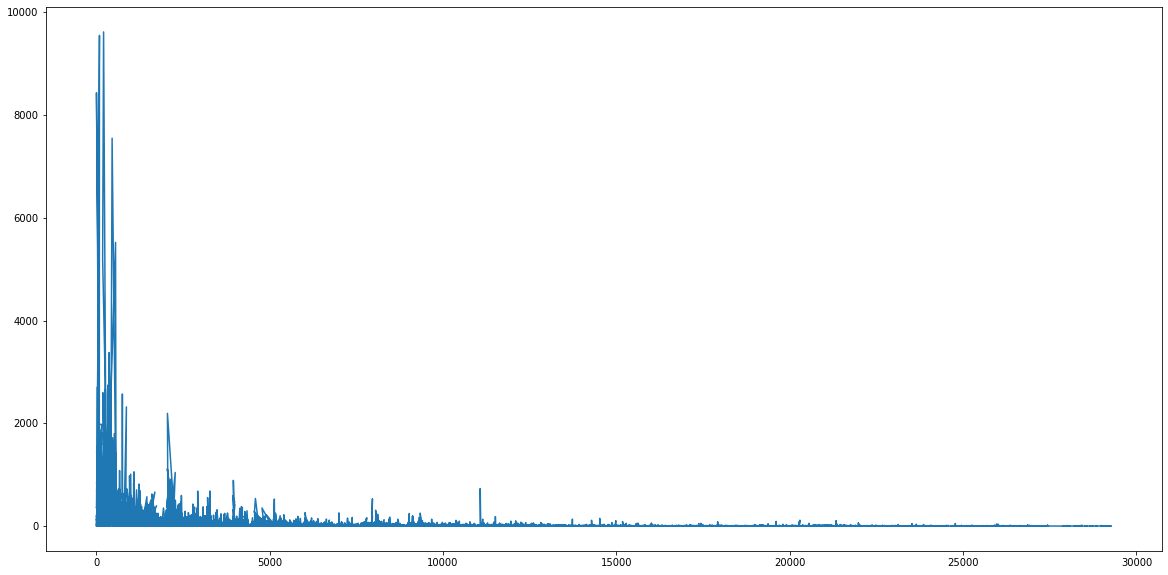

In [24]:
word_frequency.plot(figsize=(20,10))

In [25]:
document_frequency = pd.Series(dictionary.dfs)

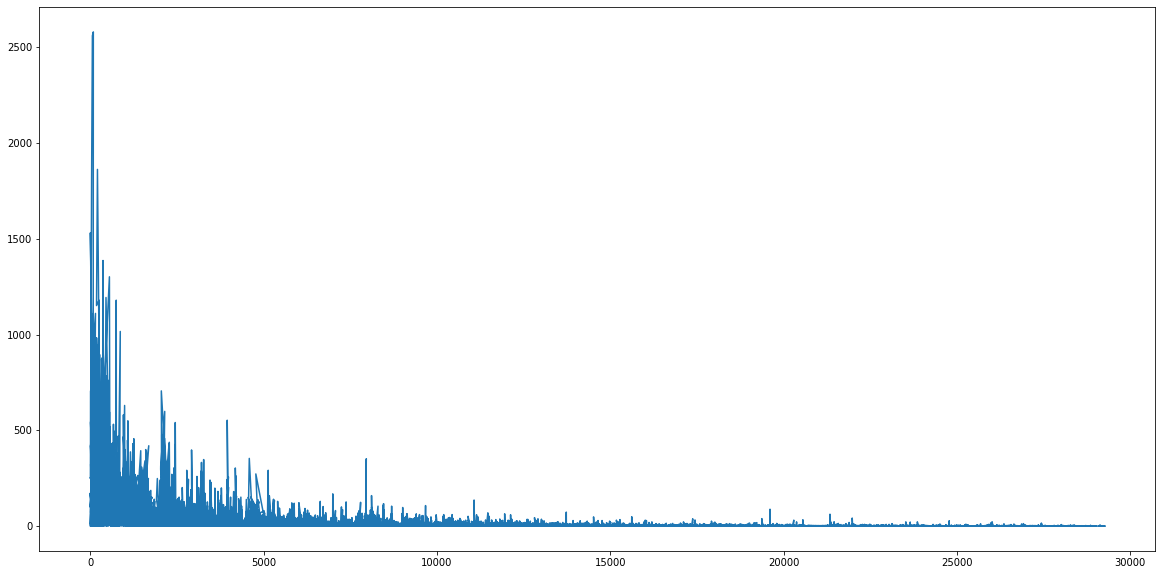

In [26]:
document_frequency.plot(figsize=(20,10))

In [27]:
document_frequency.describe()

count    29263.000000
mean        13.551276
std         59.863000
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       2578.000000
dtype: float64

### Filter out Low frequency and high frequent word

Filter out words with low word frequency

Filter out words with very high document frequency 

Filter out words with very low document frequency

In [28]:
wf_low_bound = 2
wf_up_bound = 10000000

df_low_bound = 5
df_up_bound = 2000

In [29]:
word_frequency.describe()

count    29263.000000
mean        21.348802
std        156.619962
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       9620.000000
dtype: float64

In [30]:
wf_low_list = list(word_frequency[word_frequency<wf_low_bound].index)
wf_up_list = list(word_frequency[word_frequency>wf_up_bound].index)

In [31]:
df_low_list = list(document_frequency[document_frequency<df_low_bound].index)
df_up_list = list(document_frequency[document_frequency>df_up_bound].index)

In [38]:
df_up_list

[64, 91]

#### Filter Work Check 

In [39]:
wf_low_list_word = []

for idx in wf_low_list:
    
    wf_low_list_word.append(dictionary[idx])
    

df_low_list_word = []

for idx in df_low_list:
    
    df_low_list_word.append(dictionary[idx])
    

df_up_list_word = []

for idx in df_up_list:
    
    df_up_list_word.append(dictionary[idx])

### Filter out words from BOW Model

In [41]:
filter_word_list = list(set(wf_low_list+wf_up_list+df_low_list+df_up_list))

In [42]:
len(filter_word_list)

20436

In [43]:
dictionary.filter_tokens(bad_ids=filter_word_list)

In [44]:
len(dictionary.token2id)

8827

### Word Embedding

#### BOW

In [48]:
word_embedding_bow = [dictionary.doc2bow(one_word_list) for one_word_list in text_after_preprocess]

### TF-IDF Embedding

In [49]:
tf_idf_model = TfidfModel(word_embedding_bow)

In [50]:
word_embedding_tf_idf = [tf_idf_model[one_bow] for one_bow in word_embedding_bow]

#### Fast Text Word Embedding

In [ ]:
### Skip For now

### Word Segementation

#### Test for different segmentation strategy

Setting
1. HMM=FALSE,PADDLE=FALSE,cut_all=FALSE
2. HMM=TRUE,PADDLE=FALSE,cut_all=FALSE
3. HMM=FALSE,PADDLE=TRUE,cut_all=FALSE
4. HMM=TRUE,PADDLE=TRUE,cut_all=FALSE


1 is same as 3
2 is same as 4

It depends on whether to use HMM or not.

Based on the current result, I think HMM should be adopted unless we could add enough self-defined dictionary.

Paddle does not matter that much.

In [153]:
word_cut_1 = jieba.cut(sample_text_no_punct,HMM=False,use_paddle=False,cut_all=False)
word_cut_list_1 = list(word_cut_1)

In [154]:
word_cut_2 = jieba.cut(sample_text_no_punct,HMM=True,use_paddle=False,cut_all=False)
word_cut_list_2 = list(word_cut_2)

In [155]:
word_cut_3 = jieba.cut(sample_text_no_punct,HMM=False,use_paddle=True,cut_all=False)
word_cut_list_3 = list(word_cut_3)

In [156]:
word_cut_4 = jieba.cut(sample_text_no_punct,HMM=True,use_paddle=True,cut_all=False)
word_cut_list_4 = list(word_cut_4)

In [160]:
set(word_cut_list_1) - set(word_cut_list_3)

set()

In [158]:
set(word_cut_list_2) - set(word_cut_list_1)

{'三零', '办是', '办电', '另设', '可为', '小微', '搬到', '放管服', '线上', '装三零', '装零', '通办'}

In [163]:
len(word_cut_list_1)

546

In [164]:
len(word_cut_list_2)

515

In [165]:
len(word_cut_list_3)

546

In [166]:
len(word_cut_list_4)

515

### Topic Model 

In [82]:
id2word = corpora.Dictionary(result_fenci)

In [83]:
corpus = [id2word.doc2bow(sentence) for sentence in result_fenci]

In [84]:
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('18', 1), ('一系列', 1), ('专业队伍', 1), ('严厉查处', 1), ('严峻', 1), ('中共', 1), ('中央政治局常委', 1), ('中秋', 1), ('人民', 2), ('人群', 1), ('作出', 1), ('决战', 1), ('决胜', 1), ('准备', 2), ('减灾', 1), ('力量', 1), ('十分', 1), ('协作', 1), ('压实', 3), ('压紧', 2), ('及时发现', 1), ('各方', 1), ('合力', 1), ('国务委员', 1), ('国庆', 1), ('处置', 2), ('复杂', 1), ('大火', 1), ('大灾', 1), ('小康社会', 1), ('层层', 1), ('属地', 2), ('应急', 3), ('建强', 1), ('建成', 1), ('强调', 1), ('当前', 1), ('形势', 1), ('总指挥', 1), ('总理', 2), ('意识', 1), ('手段', 1), ('扎实', 2), ('扑救', 2), ('扑灭', 1), ('执法', 1), ('批示', 2), ('指出', 2), ('指挥', 1), ('指挥部', 1), ('指示精神', 1), ('排查', 2), ('救', 1), ('救灾', 1), ('整治', 1), ('旅游', 1), ('日常', 1), ('早期', 1), ('期', 1), ('李克强', 2), ('构建', 1), ('林草', 1), ('格局', 1), ('森林草原', 7), ('森防指', 1), ('法规', 1), ('消除', 1), ('源头', 1), ('演练', 1), ('火情', 2), ('火灾', 5), ('灭火', 6), ('王勇', 2), ('生命', 1), ('生命财产', 2), ('用火', 1), ('电视电话会议', 1), ('相互配合', 1), ('秋冬季', 2), ('突发', 1), ('第一', 1), ('管控', 1), ('紧密', 1), ('紧盯', 1), ('群防群治', 1), ('至上', 1), ('节假日', 1), ('营造', 

In [55]:
corpus = word_embedding_bow
id2word = dictionary

In [61]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=5,
                # random_state=100,
                # update_every=1,
                # chunksize=100,
                # passes=10,
                # alpha='auto',
                # per_word_topics=True
                )

In [62]:
pprint(lda_model.print_topics(num_words=20))

[(0,
  '0.017*"发展" + 0.012*"就业" + 0.012*"经济" + 0.010*"中国" + 0.008*"创新" + 0.008*"合作" '
  '+ 0.007*"推动" + 0.007*"健康" + 0.006*"企业" + 0.006*"促进" + 0.006*"创业" + '
  '0.006*"改革" + 0.005*"国务院" + 0.005*"推进" + 0.004*"澳门" + 0.004*"市场" + '
  '0.004*"实现" + 0.004*"政府" + 0.004*"国家" + 0.004*"社会"'),
 (1,
  '0.020*"中国" + 0.014*"发展" + 0.012*"经济" + 0.012*"企业" + 0.011*"合作" + 0.007*"政府" '
  '+ 0.007*"创新" + 0.006*"推动" + 0.006*"世界" + 0.005*"市场" + 0.005*"推进" + '
  '0.005*"国家" + 0.005*"国务院" + 0.004*"会议" + 0.004*"改革" + 0.004*"进一步" + '
  '0.004*"部门" + 0.004*"投资" + 0.004*"领域" + 0.004*"中方"'),
 (2,
  '0.015*"发展" + 0.010*"企业" + 0.007*"改革" + 0.007*"国务院" + 0.007*"经济" + '
  '0.007*"政府" + 0.007*"推进" + 0.006*"社会" + 0.006*"会议" + 0.006*"创新" + 0.006*"推动" '
  '+ 0.005*"服务" + 0.005*"促进" + 0.005*"部门" + 0.005*"就业" + 0.005*"建设" + '
  '0.005*"国家" + 0.004*"加快" + 0.004*"支持" + 0.004*"群众"'),
 (3,
  '0.022*"中国" + 0.016*"发展" + 0.014*"经济" + 0.011*"合作" + 0.008*"世界" + 0.008*"国际" '
  '+ 0.006*"企业" + 0.006*"促进" + 0.005*"推动" + 0.005*"国务院" + 

In [64]:
coherence_model_lda

In [66]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_after_preprocess, dictionary=id2word, coherence='c_v')

In [67]:
coherence_lda = coherence_model_lda.get_coherence()

In [68]:
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3635532850096101


In [70]:
lda_model.log_perplexity(corpus)

-7.594107021920879

In [72]:
coherence_values = []
model_list = []

for num_topics in range(2,41,2):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics,
                    # random_state=100,
                    # update_every=1,
                    # chunksize=100,
                    # passes=10,
                    # alpha='auto',
                    # per_word_topics=True
                                               )
                                                
    model_list.append(lda_model)
    coherencemodel = CoherenceModel(model=lda_model, texts=text_after_preprocess, dictionary=id2word, coherence='c_v')
    coherence_values.append(round(coherencemodel.get_coherence(),3))

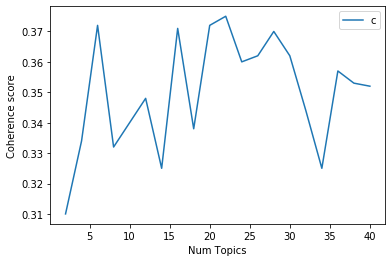

In [73]:
x = range(2,41,2)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [74]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.31
Num Topics = 4  has Coherence Value of 0.334
Num Topics = 6  has Coherence Value of 0.372
Num Topics = 8  has Coherence Value of 0.332
Num Topics = 10  has Coherence Value of 0.34
Num Topics = 12  has Coherence Value of 0.348
Num Topics = 14  has Coherence Value of 0.325
Num Topics = 16  has Coherence Value of 0.371
Num Topics = 18  has Coherence Value of 0.338
Num Topics = 20  has Coherence Value of 0.372
Num Topics = 22  has Coherence Value of 0.375
Num Topics = 24  has Coherence Value of 0.36
Num Topics = 26  has Coherence Value of 0.362
Num Topics = 28  has Coherence Value of 0.37
Num Topics = 30  has Coherence Value of 0.362
Num Topics = 32  has Coherence Value of 0.344
Num Topics = 34  has Coherence Value of 0.325
Num Topics = 36  has Coherence Value of 0.357
Num Topics = 38  has Coherence Value of 0.353
Num Topics = 40  has Coherence Value of 0.352


In [100]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.026*"中国" + 0.020*"合作" + 0.020*"发展" + 0.012*"经济" + 0.010*"企业" + 0.006*"创新" '
  '+ 0.006*"推动" + 0.006*"国家" + 0.005*"市场" + 0.005*"中方"'),
 (1,
  '0.029*"合作" + 0.024*"中国" + 0.019*"发展" + 0.010*"国家" + 0.010*"中方" + 0.009*"经济" '
  '+ 0.009*"关系" + 0.008*"领域" + 0.007*"加强" + 0.007*"地区"'),
 (2,
  '0.015*"发展" + 0.013*"企业" + 0.011*"经济" + 0.009*"创新" + 0.009*"改革" + 0.007*"推进" '
  '+ 0.007*"政府" + 0.007*"国务院" + 0.007*"中国" + 0.007*"推动"'),
 (3,
  '0.026*"发展" + 0.015*"合作" + 0.013*"经济" + 0.008*"中国" + 0.008*"推动" + 0.006*"加强" '
  '+ 0.006*"促进" + 0.005*"中方" + 0.005*"推进" + 0.005*"建设"'),
 (4,
  '0.016*"就业" + 0.014*"发展" + 0.007*"经济" + 0.007*"中国" + 0.007*"社会" + 0.006*"政府" '
  '+ 0.006*"国务院" + 0.005*"群众" + 0.005*"企业" + 0.005*"建设"'),
 (5,
  '0.019*"中国" + 0.016*"发展" + 0.009*"经济" + 0.008*"合作" + 0.008*"国务院" + '
  '0.006*"国家" + 0.006*"世界" + 0.005*"会议" + 0.005*"国际" + 0.005*"企业"')]


In [101]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),                 round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    # print(contents)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    # print(sent_topics_df)
    return(sent_topics_df)

In [102]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=text_after_preprocess)

In [125]:
topic_1 = df_topic_sents_keywords[df_topic_sents_keywords["Dominant_Topic"]==5.0]

In [126]:
topic_1.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
8,5.0,0.5951,"中国, 发展, 经济, 合作, 国务院, 国家, 世界, 会议, 国际, 企业","[外交部, 发言人, 赵立坚, 宣布, 国务院, 总理, 李克强, 出席, 世界, 经济, ..."
18,5.0,0.4760,"中国, 发展, 经济, 合作, 国务院, 国家, 世界, 会议, 国际, 企业","[李克强, 总理, 主持, 召开, 国务院, 常务会议, 部署, 防汛, 救灾, 灾后, 恢..."
32,5.0,0.8858,"中国, 发展, 经济, 合作, 国务院, 国家, 世界, 会议, 国际, 企业","[李克强, 上午, 时许, 飞抵, 重庆, 飞机, 马上转, 乘火车, 汽车, 一路, 辗转..."
34,5.0,0.8129,"中国, 发展, 经济, 合作, 国务院, 国家, 世界, 会议, 国际, 企业","[第三个, 中国, 医师, 中共, 中央政治局常委, 国务院, 总理, 李克强, 作出, 重..."
93,5.0,0.6018,"中国, 发展, 经济, 合作, 国务院, 国家, 世界, 会议, 国际, 企业","[中共, 中央政治局常委, 国务院, 总理, 中央, 应对, 新冠, 肺炎, 疫情, 领导小..."


In [127]:
representative_text = list(topic_1.sort_values("Perc_Contribution",ascending=False)[0][0:10])

In [128]:
representative_text[1]

['国务院',
 '总理',
 '李克强',
 '时间',
 '上午',
 '纽约联合国总部',
 '出席',
 '联大',
 '解决',
 '难民',
 '移民',
 '大规模',
 '流动',
 '高级别',
 '会议',
 '发言',
 '全文如下',
 '主席',
 '同事',
 '一个多月',
 '奥运会',
 '开幕式',
 '首支',
 '难民',
 '代表队',
 '亮相',
 '世界',
 '运动员',
 '勇气',
 '毅力',
 '告诉',
 '国际',
 '社会',
 '背井离乡',
 '居无定所',
 '依然',
 '选择',
 '希望',
 '梦想',
 '拼搏',
 '值得',
 '尊重',
 '难民',
 '移民',
 '日益突出',
 '会议',
 '联合国',
 '成立',
 '首次',
 '应对',
 '难民',
 '移民',
 '大规模',
 '流动',
 '高级别',
 '会议',
 '引起',
 '国际',
 '社会',
 '高度',
 '关注',
 '我谈',
 '几点',
 '看法',
 '难民',
 '移民',
 '关乎',
 '世界',
 '和平',
 '发展',
 '影响',
 '地区',
 '稳定',
 '难民',
 '移民',
 '大规模',
 '引发',
 '一系列',
 '政治',
 '经济',
 '社会',
 '全球',
 '难民',
 '移民',
 '数量',
 '之多',
 '增长',
 '之快',
 '几十年',
 '国家',
 '发展',
 '带来',
 '冲击',
 '威胁',
 '地区',
 '和平',
 '稳定',
 '拖累',
 '世界',
 '经济',
 '复苏',
 '影响',
 '国际',
 '秩序',
 '还给',
 '恐怖主义',
 '带来',
 '可乘之机',
 '难民',
 '移民',
 '既有',
 '地区性',
 '全球性',
 '国家',
 '置身事外',
 '国际',
 '社会',
 '应对',
 '难民',
 '移民',
 '一场',
 '人道主义',
 '危机',
 '拷问',
 '人类',
 '社会',
 '良知',
 '生活',
 '同一个',
 '地球村',
 '生命',
 '宝贵',
 '尊严',
 '维护',
 '难民',
 '颠沛流离',
 '经受'